### **The aim of this assignment is to predict auto insurance pricing using ML algorithms. The target is `Response_Market_Index`, and the id column is `Id`. The features are both numerical and categorical.**




For a better understanding of the target, it is important to understand that "***A market index is a hypothetical portfolio of investment holdings that represents a segment of the financial market.***" [investopedia.com]



In [3]:
import numpy as np
import sklearn
from sklearn import datasets
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

## 1. Loading the data

In [4]:
dataset_type = pd.read_csv('data_type.csv', sep=';')
variable_types = dict(zip(dataset_type.VarName, dataset_type.Type))
dataset = pd.read_csv('data_train_insurance.csv', sep=';', dtype=variable_types, na_values='?')

In [5]:
dataset.shape

(9983, 40)

In [6]:
dataset.head()

,Id,Response_Market_Index,PROD_Formula,PER_sex,PER_Sex_Second_Driver,VEH_Actual_Value,CLA_HISTORY,CLA_HISTORY_1Y,CLA_HISTORY_3Y,CLA_BM_TPL_DECLARED,BEH_Mileage,PER_KIDS_ON_BOARD_ID,VEH_Number_of_doors,VEH_Top_Speed,BEH_Number_Year_Insured,VEH_TransmissionId,PER_Age_Main_Driver,PER_License_Age_Main_Driver,PER_License_Age_Second_Driver,PER_Matrimonial_Status,VEH_Age,VEH_Injection_Mode,VEH_fuel_type,BEH_vehicule_usage,VEH_Drive_type,VEH_Body,VEH_Segment,PER_Parking_Type,CLA_BM,VEH_engine_HP,VEH_pw_proportion,VEH_High_Risk_Vehicle,PER_previous_insurer,PER_Is_second_driver,PER_Age_oldest_child,PER_Second_Driver_Age,PER_Insured_Before,VEH_Weight,GEO_Lat,GEO_Long
0,1638099,435.0,BASIC,2,0,4600.0,1.0,1.0,1.0,1.0,13.0,3,4.0,160.0,10.0,7,59.0,31.0,-1.0,2,15.0,389999,1,1,50001,9,30003,3,10.0,90.0,59.0,2,5,1,-99.0,-1.0,2,1125.0,-1.790876,-0.431147
1,1657342,609.0,FULL,1,0,68315.0,1.0,1.0,1.0,2.0,15.0,1,5.0,248.0,6.0,7,32.0,15.0,-1.0,2,3.0,380002,1,1,50002,9,30005,1,6.0,218.0,106.0,2,17,1,2.0,-1.0,2,1510.0,1.675824,-4.431147
2,1657529,609.0,FULL,1,0,68315.0,1.0,1.0,1.0,2.0,15.0,1,5.0,248.0,6.0,7,32.0,15.0,-1.0,2,3.0,380002,1,1,50002,9,30005,1,6.0,218.0,106.0,2,17,1,2.0,-1.0,2,1510.0,1.675824,-4.431147
3,1662071,404.0,FULL,1,2,11005.0,1.0,1.0,1.0,2.0,14.0,1,5.0,173.0,7.0,7,31.0,7.0,12.0,2,8.0,380002,1,1,50001,9,30002,3,7.0,80.0,51.0,2,6,2,1.0,31.0,2,1170.0,-0.440876,1.285553
4,1662074,404.0,FULL,1,2,11005.0,1.0,1.0,1.0,2.0,14.0,1,5.0,173.0,7.0,7,31.0,7.0,12.0,2,8.0,380002,1,1,50001,9,30002,3,7.0,80.0,51.0,2,6,2,1.0,31.0,2,1170.0,-0.440876,1.285553


## 2. Analysis of missing values

In [7]:
dataset.isnull().sum(axis=0)

Id                                  0
Response_Market_Index               0
PROD_Formula                        0
PER_sex                             0
PER_Sex_Second_Driver               0
VEH_Actual_Value                    0
CLA_HISTORY                        50
CLA_HISTORY_1Y                     50
CLA_HISTORY_3Y                     50
CLA_BM_TPL_DECLARED                50
BEH_Mileage                        50
PER_KIDS_ON_BOARD_ID               50
VEH_Number_of_doors               766
VEH_Top_Speed                      50
BEH_Number_Year_Insured            50
VEH_TransmissionId                 50
PER_Age_Main_Driver                50
PER_License_Age_Main_Driver        50
PER_License_Age_Second_Driver    1052
PER_Matrimonial_Status           1052
VEH_Age                            50
VEH_Injection_Mode               2563
VEH_fuel_type                      50
BEH_vehicule_usage                 50
VEH_Drive_type                     50
VEH_Body                           50
VEH_Segment 

We know that the dataset has a certain number of `NaN` values defined by `?`, however it does not mean they are the only missing or null values. We want to check each column for values that could represent a null value. We can note that `-1` and `-99` are strange values for features like `PER_Second_Driver_Age` and `PER_Age_oldest_child` because we cannot have a negative age. The feature `PER_Sex_Second_Driver` is a bit of a challenge too because there are three different values. However, based on the values of the feature `PER_sex`, we may assume that `0` represents nor male or female, but can be 'unknown' or 'no second driver' for example.



In [8]:
dataset[['PER_Age_oldest_child','PER_Second_Driver_Age','PER_License_Age_Second_Driver']].replace([-99,-1], np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [9]:
for column in dataset:
    print (dataset[column].value_counts())

1686591    1
1713245    1
1698568    1
1667823    1
1701576    1
          ..
1703293    1
1696492    1
1708444    1
1683368    1
1705206    1
Name: Id, Length: 9983, dtype: int64
349.00    146
319.00    136
339.00    120
309.00    114
279.00    102
         ... 
388.67      1
573.25      1
397.07      1
349.52      1
303.87      1
Name: Response_Market_Index, Length: 2061, dtype: int64
FULL     6343
BASIC    3640
Name: PROD_Formula, dtype: int64
1    7628
2    2355
Name: PER_sex, dtype: int64
0    8402
2    1082
1     499
Name: PER_Sex_Second_Driver, dtype: int64
0.0        107
2900.0      67
6800.0      49
5900.0      48
2300.0      47
          ... 
10780.0      1
12588.0      1
11790.0      1
4717.0       1
5975.0       1
Name: VEH_Actual_Value, Length: 2326, dtype: int64
1.0     8413
2.0     1128
11.0     392
Name: CLA_HISTORY, dtype: int64
1.0     9485
2.0      360
11.0      88
Name: CLA_HISTORY_1Y, dtype: int64
1.0     8882
2.0      823
11.0     228
Name: CLA_HISTORY_3Y, dtype: 

I choose not to set as `NaN` cells with values `-99` or `-1` for the columns `['PER_previous_insurer','PER_License_Age_Second_Driver','VEH_Top_Speed','CLA_BM_TPL_DECLARED']`. They may all be referencing null or missing values, but without proper documentation it is difficult to be sure. The value `-1` in the column `PER_previous_insurer` for example may be a code for an insurer abroad or an insurer that is no longer in the market. Setting those values as `NaN` also mixes up values that were previously defined as `?` (verified null values) and `-99` or `-1` (potential null values) for this set of columns.

In [10]:
dataset.PROD_Formula = dataset.PROD_Formula.replace(['FULL','BASIC'],[1,0])

In [11]:
import missingno as msno

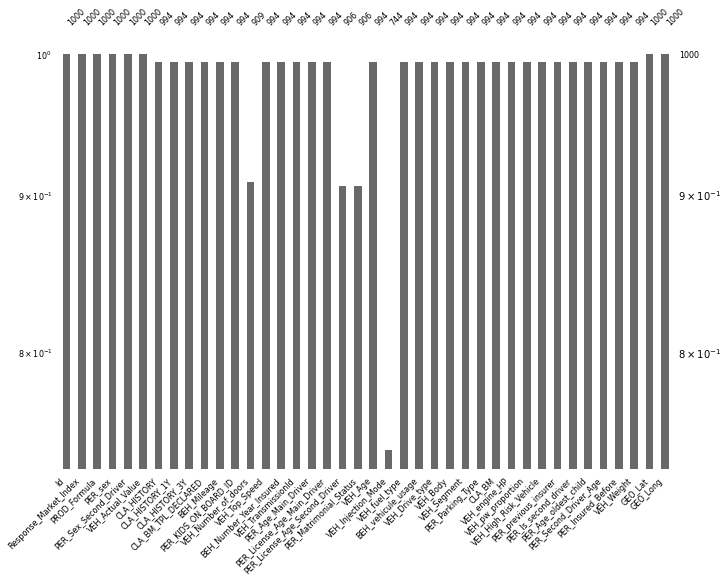

In [12]:
msno.bar(dataset.sample(1000),log=True,figsize=(11, 8),fontsize=8)

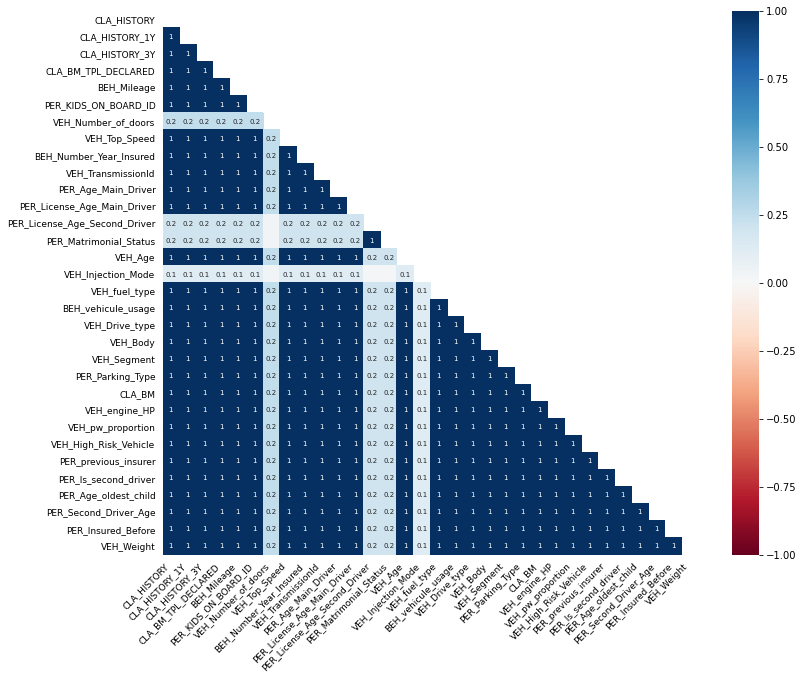

In [13]:
msno.heatmap(dataset,figsize=(12, 10),fontsize=9)

The previous heatmap helps us understand how strongly the presence or absence of one variable affects the presence of another. For example, if `CLA_HISTORY` appears then all other variables appear except for `VEH_Injection_Mode`, `PER_Matrimonial_Status`, `PER_License_Age_Second_Driver` and `VEH_Number_of_doors`. The good news is that we can make the same observation for most of the features. 

On the other hand, for example, `VEH_Injection_Mode` appearing or not appearing seems to have almost no impact on the appearance or non-appearance of `VEH_weight`.


In [14]:
dataset_nan = dataset[dataset.isnull().sum(axis=1) > 31] #keep rows with more than 31 NaN

In [15]:
dataset_nan.shape

(50, 40)

Previously, we saw that a majority of features have exactly 50 `NaN` values. It seemed interesting to try and extract the rows containing many null values and see if it is always the same observations that lack some values.

In [16]:
dataset_nan.head(10).transpose()

,2304,2305,2307,2310,2325,2326,2686,2687,2745,2754
Id,1681939,1681941,1681945,1681949,1681985,1681986,1684589,1684591,1684831,1684876
Response_Market_Index,287,287,368,368,287,287,289.82,289.82,327.14,279
PROD_Formula,0,1,0,0,1,1,0,1,0,1
PER_sex,1,1,1,1,1,1,2,2,1,1
PER_Sex_Second_Driver,0,0,0,0,0,0,0,0,2,2
VEH_Actual_Value,35919,35919,5200,5200,35919,35919,15835,15835,22876,22876
CLA_HISTORY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLA_HISTORY_1Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLA_HISTORY_3Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLA_BM_TPL_DECLARED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
dataset_nan.index #observations lacking the majority of values

Int64Index([2304, 2305, 2307, 2310, 2325, 2326, 2686, 2687, 2745, 2754, 2758,
            2766, 3457, 3458, 3474, 3479, 3654, 4225, 4226, 5148, 5398, 5503,
            5518, 5519, 5659, 5664, 5811, 6814, 6816, 6820, 7006, 7020, 7615,
            7616, 7945, 7975, 7981, 7989, 8362, 8363, 8386, 9012, 9013, 9014,
            9497, 9503, 9504, 9505, 9869, 9932],
           dtype='int64')

Actually, it seems that there is a specific set of rows that have exactly 32 the missing values, out of 40. The rest of the rows are fairly complete (less than 3 `NaN`). It may be because of a change in data collection throughout the years. It can be interesting to set those rows apart for now.

## 3. Univariate analysis of features and target

### The target


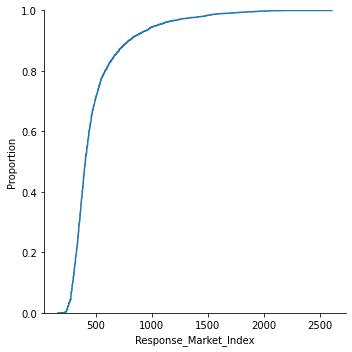

In [18]:
sn.displot(dataset, x='Response_Market_Index', kind='ecdf')
plt.show()

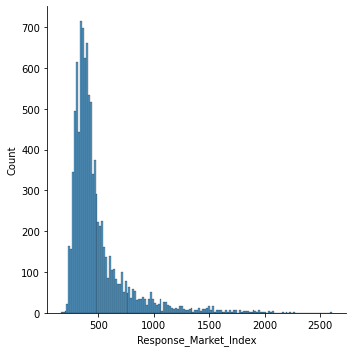

In [19]:
sn.displot(dataset.Response_Market_Index)

Around 80% of the target values are under 700, with a distribution close to the log-normal distribution. However, the dataset below shows that the target `Response_Market_Index` can vary a lot, with a minimum at 162 and a maximum at 2605, which is higher than the third quartile (530). This can be confirmed by the presence of a long tail, containing possible outliers that are nonetheless valid points to consider.

In [20]:
dataset.Response_Market_Index.describe().transpose()

count    9983.000000
mean      493.635824
std       268.707675
min       162.000000
25%       341.580000
50%       407.070000
75%       530.000000
max      2604.930000
Name: Response_Market_Index, dtype: float64

### The features

In [21]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Response_Market_Index,9983.0,493.635824,268.707675,162.000000,341.580000,407.070000,530.000000,2.604930e+03
PROD_Formula,9983.0,0.635380,0.481348,0.000000,0.000000,1.000000,1.000000,1.000000e+00
VEH_Actual_Value,9983.0,20769.225483,24733.604888,-1765.000000,7803.000000,14998.000000,26882.500000,1.132190e+06
CLA_HISTORY,9933.0,1.508205,1.949901,1.000000,1.000000,1.000000,1.000000,1.100000e+01
CLA_HISTORY_1Y,9933.0,1.124836,0.952200,1.000000,1.000000,1.000000,1.000000,1.100000e+01
CLA_HISTORY_3Y,9933.0,1.312393,1.510256,1.000000,1.000000,1.000000,1.000000,1.100000e+01
CLA_BM_TPL_DECLARED,9933.0,1.646431,2.180726,-1.000000,1.000000,1.000000,1.000000,1.200000e+01
BEH_Mileage,9933.0,13.309977,1.016209,12.000000,13.000000,13.000000,14.000000,1.800000e+01
VEH_Number_of_doors,9217.0,4.612455,0.726908,2.000000,4.000000,5.000000,5.000000,5.000000e+00
VEH_Top_Speed,9933.0,187.541830,24.391045,0.000000,175.000000,187.000000,201.000000,3.250000e+02


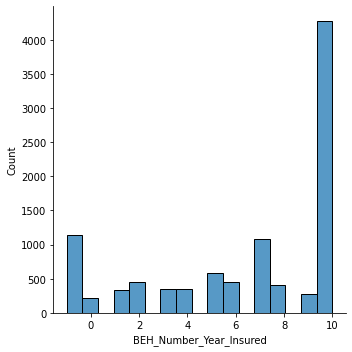

In [22]:
sn.displot(dataset.BEH_Number_Year_Insured)

In [23]:
dataset.describe(include=['O']).transpose()

,count,unique,top,freq
Id,9983,9983,1686591,1
PER_sex,9983,2,1,7628
PER_Sex_Second_Driver,9983,3,0,8402
PER_KIDS_ON_BOARD_ID,9933,3,2,3840
VEH_TransmissionId,9933,2,7,9074
PER_Matrimonial_Status,8931,4,2,5826
VEH_Injection_Mode,7420,5,389999,3719
VEH_fuel_type,9933,2,1,5506
BEH_vehicule_usage,9933,1,1,9933
VEH_Drive_type,9933,8,50001,8575


Since the feature `BEH_vehicule_usage` takes a unique value, we can remove it from the dataset.

In [24]:
dataset = dataset.drop(columns='BEH_vehicule_usage')

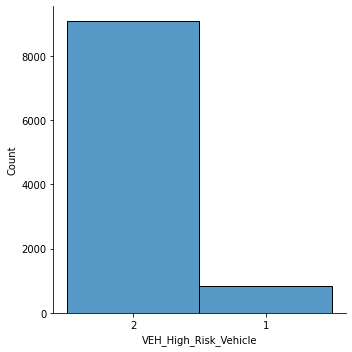

In [25]:
sn.displot((dataset.drop(dataset_nan.index))['VEH_High_Risk_Vehicle'])

We can safely assume that most cars insured are not high risk (which would correspond to the value `2` for the column `VEH_High_Risk_Vehicle`). The previous plot then shows that the majority (9090/9933) of cars are not high risk.

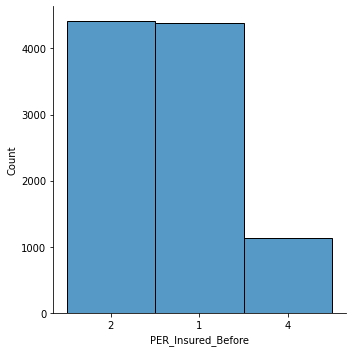

In [26]:
sn.displot((dataset.drop(dataset_nan.index))['PER_Insured_Before'])

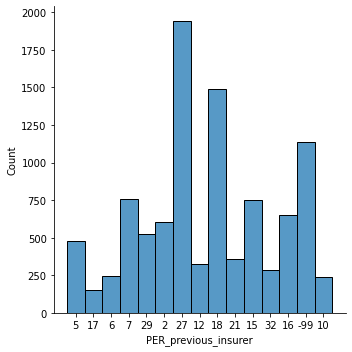

In [27]:
sn.displot((dataset.drop(dataset_nan.index))['PER_previous_insurer'])



## 4. Multivariate analysis to capture relation between features and target

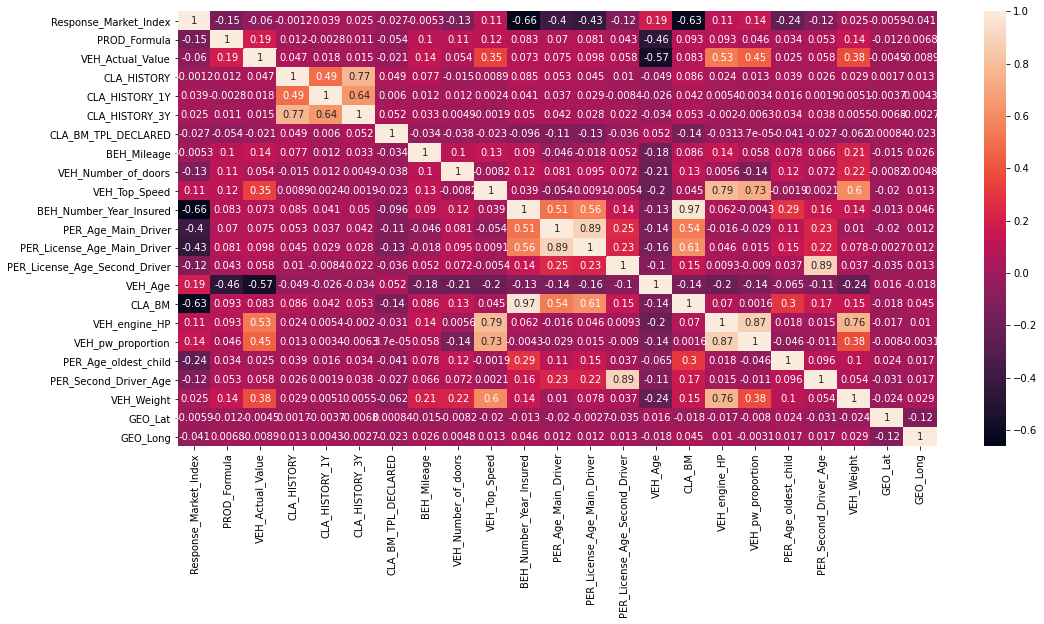

In [28]:
corrMatrix = dataset.corr()
plt.figure(figsize = (17,8))
sn.heatmap(corrMatrix, annot=True)
plt.show()

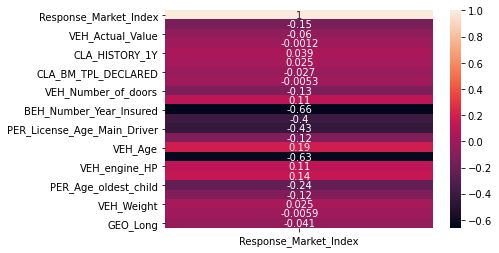

In [29]:
sn.heatmap(pd.DataFrame(corrMatrix['Response_Market_Index']), annot=True)


The features with the highest correlation to the target are `VEH_Age`, `VEH_Number_of_doors`, `PER_License_Age_Main_Driver` and `BEH_Number_Year_Insured`. This is natural, because those are the factors that contribute to a risk of incident or need for repair for cars. The older the car, the more likely it will deteriorate, and will need fixing. The number of doors is strongly linked to the weight and size of the car, therefore this can also be a source of incident. The bigger the car, the bigger the risk for an accident while parking for example. The same goes for the experience of the main driver, a new driver will be more prone to making mistakes. Lastly, how long the car has been insured also matters in the same way, we can actually see that `BEH_Number_Year_Insured` is strongly correlated to `PER_License_Age_Main_Driver` (`0.56`).

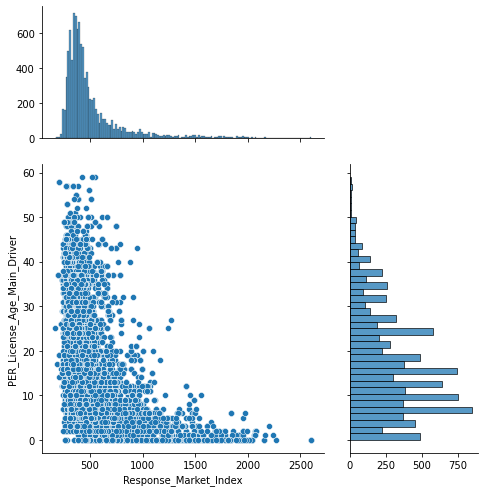

In [30]:
sn.jointplot(x='Response_Market_Index', y='PER_License_Age_Main_Driver', data=dataset, height=7, ratio=2, marginal_ticks=True)

In the previous jointplot, we can clearly see that the response market index is four times higher for non-experienced  (less than 10 years driving) than for experienced drive (more than 40 years). 

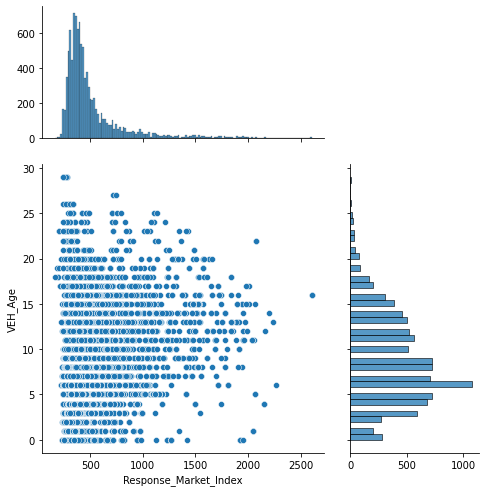

In [31]:
sn.jointplot(x='Response_Market_Index', y='VEH_Age', data=dataset, height=7, ratio=2, marginal_ticks=True)

We notice a sort of rotated bell shape, indicating that the response market index is lower for new cars (less than 5 years) and older cars (greater than 20 years). But it is higher for cars around 10 and 20 years. It is possible that, the way cars are manifactured, it is between 10 and 20 years that car components deteriorate. After 20 years, it is probable that what needed fixing has already been fixed.



## 5. Preparing for modeling

For modeling, we keep the original dataset, but we are removing the 50 rows with a lot of missing data. This is a very small number of rows compared to the size of the dataset, however it can be interesting to analyse those rows separately later on.

In [32]:
dataset_mod = dataset.drop(index=dataset_nan.index) #drop rows with 32/40 NaN values

In [33]:
dataset_mod.head()

,Id,Response_Market_Index,PROD_Formula,PER_sex,PER_Sex_Second_Driver,VEH_Actual_Value,CLA_HISTORY,CLA_HISTORY_1Y,CLA_HISTORY_3Y,CLA_BM_TPL_DECLARED,BEH_Mileage,PER_KIDS_ON_BOARD_ID,VEH_Number_of_doors,VEH_Top_Speed,BEH_Number_Year_Insured,VEH_TransmissionId,PER_Age_Main_Driver,PER_License_Age_Main_Driver,PER_License_Age_Second_Driver,PER_Matrimonial_Status,VEH_Age,VEH_Injection_Mode,VEH_fuel_type,VEH_Drive_type,VEH_Body,VEH_Segment,PER_Parking_Type,CLA_BM,VEH_engine_HP,VEH_pw_proportion,VEH_High_Risk_Vehicle,PER_previous_insurer,PER_Is_second_driver,PER_Age_oldest_child,PER_Second_Driver_Age,PER_Insured_Before,VEH_Weight,GEO_Lat,GEO_Long
0,1638099,435.0,0,2,0,4600.0,1.0,1.0,1.0,1.0,13.0,3,4.0,160.0,10.0,7,59.0,31.0,-1.0,2,15.0,389999,1,50001,9,30003,3,10.0,90.0,59.0,2,5,1,-99.0,-1.0,2,1125.0,-1.790876,-0.431147
1,1657342,609.0,1,1,0,68315.0,1.0,1.0,1.0,2.0,15.0,1,5.0,248.0,6.0,7,32.0,15.0,-1.0,2,3.0,380002,1,50002,9,30005,1,6.0,218.0,106.0,2,17,1,2.0,-1.0,2,1510.0,1.675824,-4.431147
2,1657529,609.0,1,1,0,68315.0,1.0,1.0,1.0,2.0,15.0,1,5.0,248.0,6.0,7,32.0,15.0,-1.0,2,3.0,380002,1,50002,9,30005,1,6.0,218.0,106.0,2,17,1,2.0,-1.0,2,1510.0,1.675824,-4.431147
3,1662071,404.0,1,1,2,11005.0,1.0,1.0,1.0,2.0,14.0,1,5.0,173.0,7.0,7,31.0,7.0,12.0,2,8.0,380002,1,50001,9,30002,3,7.0,80.0,51.0,2,6,2,1.0,31.0,2,1170.0,-0.440876,1.285553
4,1662074,404.0,1,1,2,11005.0,1.0,1.0,1.0,2.0,14.0,1,5.0,173.0,7.0,7,31.0,7.0,12.0,2,8.0,380002,1,50001,9,30002,3,7.0,80.0,51.0,2,6,2,1.0,31.0,2,1170.0,-0.440876,1.285553


In [34]:
dataset_mod[dataset_mod.isnull().sum(axis=1) > 0].transpose() #keep rows with any NaN

,14,22,32,38,55,77,86,87,123,126,139,140,143,151,154,160,161,168,179,182,183,197,199,200,203,210,212,225,237,238,256,257,258,259,260,261,262,263,264,265,...,9728,9729,9734,9773,9774,9776,9778,9779,9783,9798,9799,9806,9807,9808,9809,9828,9829,9830,9831,9840,9841,9844,9855,9856,9858,9861,9876,9877,9878,9882,9892,9893,9900,9901,9913,9933,9941,9942,9974,9977
Id,1662225,1662262,1662461,1662511,1662568,1662746,1662799,1662800,1663385,1663446,1663869,1663873,1663876,1663935,1663977,1664016,1664017,1664096,1664191,1664197,1664212,1664365,1664367,1664369,1664474,1664635,1664639,1664669,1664919,1664920,1665054,1665090,1665091,1665093,1665094,1665100,1665101,1665102,1665104,1665105,...,1712517,1712518,1712547,1712630,1712631,1712635,1712651,1712661,1712679,1712751,1712752,1712828,1712829,1712830,1712831,1712915,1712919,1712920,1712922,1712935,1712936,1712956,1712993,1712994,1712997,1713018,1713043,1713044,1713049,1713076,1713098,1713099,1713114,1713115,1713156,1713215,1713242,1713243,1713305,1713308
Response_Market_Index,333,295.4,295.4,494,643,643,437,437,407,359,303,303,399,399,407,479,479,460,379,280.05,280.05,329,386.02,329,386.02,292,292,353,408,408,362.01,366,385,569.28,569.28,366,569.28,861,715,579,...,301,301,357,374,321.28,374,333,367.37,321.28,363,363,333,467,467,467,950,383.31,383.31,619,369,369,619,579,778,619,369,749,608,609,409.44,638,415.99,1122,1122,1122,403,610,610,403,326
PROD_Formula,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,...,1,1,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
PER_sex,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,2,2,2,1,1,1,1,2,2,1,1,1,2,2,1,1,1,2,1,2,2,1,...,1,1,1,2,2,2,2,1,2,1,1,2,1,1,1,1,1,1,1,2,2,1,2,2,1,2,2,2,2,1,2,1,2,2,2,1,1,1,1,1
PER_Sex_Second_Driver,0,2,2,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
VEH_Actual_Value,2700,3400,3400,842600,2100,2100,1600,1600,6100,1800,2500,2500,22294,22294,6100,3400,3400,6800,2700,31443,31443,11933,2900,11933,2900,3400,3400,2700,2100,2100,40867,30873,2400,10200,10200,30873,10200,10700,6300,20250,...,3400,3400,2900,1900,1800,1900,1750,8225,1800,2000,2000,1750,23510,23510,23510,9156,2100,2100,9156,40630,40630,9156,2300,2300,9156,40630,2300,2300,2300,2125,2300,4600,2400,2400,2400,3175,1900,1900,3175,2287
CLA_HISTORY,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CLA_HISTORY_1Y,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CLA_HISTORY_3Y,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CLA_BM_TPL_DECLARED,1,1,1,1,-1,-1,5,5,1,1,1,1,4,4,1,1,1,1,7,1,1,2,1,2,1,1,1,2,1,1,1,1,1,1,1,1,1,7,7,-1,...,1,1,1,7,1,7,1,1,1,1,1,1,2,2,2,6,1,1,6,1,1,6,7,7,6,1,7,7,7,1,7,1,-1,-1,-1,1,1,1,1,1


In [35]:
dataset_mod[dataset_mod.isnull().sum(axis=1) > 0].isnull().sum(axis=0)

Id                                  0
Response_Market_Index               0
PROD_Formula                        0
PER_sex                             0
PER_Sex_Second_Driver               0
VEH_Actual_Value                    0
CLA_HISTORY                         0
CLA_HISTORY_1Y                      0
CLA_HISTORY_3Y                      0
CLA_BM_TPL_DECLARED                 0
BEH_Mileage                         0
PER_KIDS_ON_BOARD_ID                0
VEH_Number_of_doors               716
VEH_Top_Speed                       0
BEH_Number_Year_Insured             0
VEH_TransmissionId                  0
PER_Age_Main_Driver                 0
PER_License_Age_Main_Driver         0
PER_License_Age_Second_Driver    1002
PER_Matrimonial_Status           1002
VEH_Age                             0
VEH_Injection_Mode               2513
VEH_fuel_type                       0
VEH_Drive_type                      0
VEH_Body                            0
VEH_Segment                         0
PER_Parking_

We notice that there are 4 features with a high number of null values : `VEH_Number_of_doors`, `PER_License_Age_Second_Driver`, `PER_Matrimonial_Status` and `VEH_Injection_Mode`. The other features register no null values.

In the correlation matrix, we saw that `PER_License_Age_Second_Driver` is highly correlated to `PER_Second_Driver_Age`. We can replace the missing values with the non-null values of `PER_License_Age_Second_Driver` for the same value of `PER_Second_Driver_Age`. 



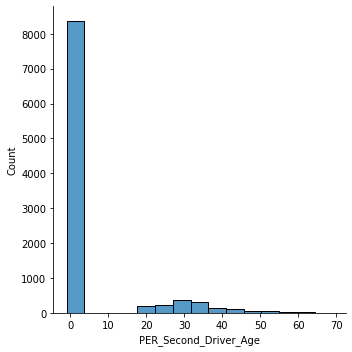

In [36]:
sn.displot(dataset_mod['PER_Second_Driver_Age'])

The majority of values taken by `PER_Second_Driver_Age` is `0`. This may mean that there is no registered second driver for a given car.

In [37]:
dataset_mod['PER_License_Age_Second_Driver'] = dataset_mod.groupby('PER_Second_Driver_Age')['PER_License_Age_Second_Driver'].apply(lambda x: x.ffill().bfill())

In [38]:
dataset_mod[['PER_Second_Driver_Age','PER_License_Age_Second_Driver']].transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9943,9944,9945,9946,9947,9948,9949,9950,9951,9952,9953,9954,9955,9956,9957,9958,9959,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982
PER_Second_Driver_Age,-1.0,-1.0,-1.0,31.0,31.0,-1.0,31.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,31.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,33.0,-1.0,-1.0,-1.0,-1.0,53.0,-1.0,-1.0,-1.0,-1.0,33.0,30.0,30.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,49.0,40.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,18.0,-1.0,24.0,-1.0,24.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
PER_License_Age_Second_Driver,-1.0,-1.0,-1.0,12.0,12.0,-1.0,12.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,11.0,-1.0,-1.0,-1.0,-1.0,35.0,-1.0,-1.0,-1.0,-1.0,11.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,17.0,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


The same goes for `VEH_Number_of_doors`. We can use the correlation (around 0.22 in absolute value) with `VEH_Age` and `VEH_Weight` to fill the missing date.

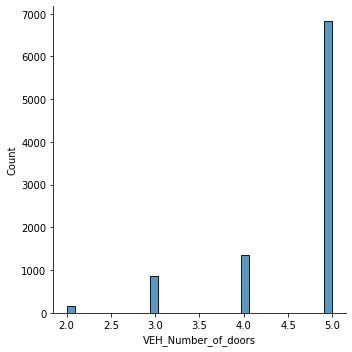

In [39]:
sn.displot(dataset_mod['VEH_Number_of_doors'])

In [40]:
dataset_mod['VEH_Number_of_doors'] = dataset_mod.groupby(['VEH_Weight','VEH_Age'])['VEH_Number_of_doors'].apply(lambda x: x.ffill().bfill())

In [41]:
dataset_mod[['VEH_Number_of_doors','VEH_Weight','VEH_Age']].transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9943,9944,9945,9946,9947,9948,9949,9950,9951,9952,9953,9954,9955,9956,9957,9958,9959,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982
VEH_Number_of_doors,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,5.0,5.0,NaN,5.0,5.0,3.0,5.0,3.0,2.0,2.0,5.0,5.0,NaN,5.0,5.0,5.0,5.0,5.0,4.0,5.0,...,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,5.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0
VEH_Weight,1125.0,1510.0,1510.0,1170.0,1170.0,1250.0,1170.0,1221.0,1033.0,1330.0,1033.0,1500.0,1285.0,1170.0,1221.0,1330.0,1500.0,1033.0,1250.0,640.0,640.0,830.0,1015.0,1250.0,1250.0,1035.0,1250.0,1245.0,1500.0,1500.0,1033.0,929.0,1015.0,1422.0,1422.0,929.0,929.0,929.0,2475.0,840.0,...,1200.0,1085.0,1085.0,1200.0,1554.0,1123.0,1520.0,1494.0,1388.0,1494.0,1194.0,1194.0,1194.0,1260.0,1260.0,1260.0,1365.0,1580.0,860.0,1580.0,1179.0,1194.0,1179.0,1410.0,1410.0,1260.0,1260.0,1260.0,1547.0,1260.0,1815.0,1049.0,1233.0,1233.0,1075.0,1233.0,1547.0,1547.0,1255.0,1815.0
VEH_Age,15.0,3.0,3.0,8.0,8.0,11.0,8.0,15.0,0.0,20.0,0.0,6.0,16.0,8.0,15.0,20.0,6.0,0.0,10.0,17.0,17.0,11.0,17.0,10.0,10.0,10.0,11.0,7.0,6.0,6.0,0.0,9.0,17.0,8.0,8.0,9.0,9.0,9.0,0.0,10.0,...,13.0,2.0,2.0,13.0,9.0,12.0,7.0,7.0,8.0,7.0,6.0,6.0,6.0,6.0,6.0,6.0,13.0,9.0,13.0,9.0,11.0,6.0,11.0,13.0,13.0,6.0,3.0,3.0,3.0,3.0,7.0,18.0,0.0,0.0,17.0,0.0,3.0,3.0,7.0,7.0


This drastically reduces the number of null values for the feature `VEH_Number_of_doors`, however there are still around 550 `NaN`s. We will use the same technique, but we will only groupby one feature instead of two.

In [42]:
dataset_mod['VEH_Number_of_doors'] = dataset_mod.groupby(['VEH_Weight'])['VEH_Number_of_doors'].apply(lambda x: x.ffill().bfill())
dataset_mod['VEH_Number_of_doors'] = dataset_mod.groupby(['VEH_Age'])['VEH_Number_of_doors'].apply(lambda x: x.ffill().bfill())

In [43]:
dataset_mod[['VEH_Number_of_doors','VEH_Weight','VEH_Age']].transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9943,9944,9945,9946,9947,9948,9949,9950,9951,9952,9953,9954,9955,9956,9957,9958,9959,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982
VEH_Number_of_doors,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,3.0,5.0,3.0,2.0,2.0,5.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,...,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0
VEH_Weight,1125.0,1510.0,1510.0,1170.0,1170.0,1250.0,1170.0,1221.0,1033.0,1330.0,1033.0,1500.0,1285.0,1170.0,1221.0,1330.0,1500.0,1033.0,1250.0,640.0,640.0,830.0,1015.0,1250.0,1250.0,1035.0,1250.0,1245.0,1500.0,1500.0,1033.0,929.0,1015.0,1422.0,1422.0,929.0,929.0,929.0,2475.0,840.0,...,1200.0,1085.0,1085.0,1200.0,1554.0,1123.0,1520.0,1494.0,1388.0,1494.0,1194.0,1194.0,1194.0,1260.0,1260.0,1260.0,1365.0,1580.0,860.0,1580.0,1179.0,1194.0,1179.0,1410.0,1410.0,1260.0,1260.0,1260.0,1547.0,1260.0,1815.0,1049.0,1233.0,1233.0,1075.0,1233.0,1547.0,1547.0,1255.0,1815.0
VEH_Age,15.0,3.0,3.0,8.0,8.0,11.0,8.0,15.0,0.0,20.0,0.0,6.0,16.0,8.0,15.0,20.0,6.0,0.0,10.0,17.0,17.0,11.0,17.0,10.0,10.0,10.0,11.0,7.0,6.0,6.0,0.0,9.0,17.0,8.0,8.0,9.0,9.0,9.0,0.0,10.0,...,13.0,2.0,2.0,13.0,9.0,12.0,7.0,7.0,8.0,7.0,6.0,6.0,6.0,6.0,6.0,6.0,13.0,9.0,13.0,9.0,11.0,6.0,11.0,13.0,13.0,6.0,3.0,3.0,3.0,3.0,7.0,18.0,0.0,0.0,17.0,0.0,3.0,3.0,7.0,7.0


For the numerical features like `PER_Matrimonial_Status` and `VEH_Injection_Mode`, we will simply use the mode to fill null values. 



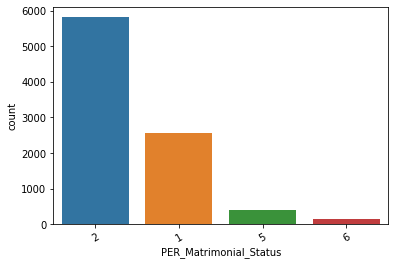

In [44]:
sn.countplot(data = dataset_mod, x = 'PER_Matrimonial_Status')
plt.xticks(rotation=30)
plt.show()

In [45]:
dataset_mod['PER_Matrimonial_Status'] = dataset_mod['PER_Matrimonial_Status'].fillna((dataset_mod['PER_Matrimonial_Status'].mode()[0]))

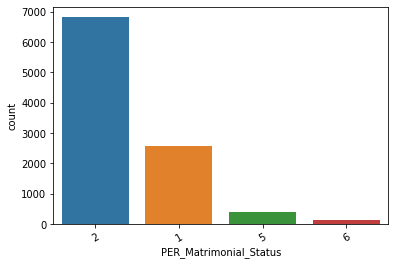

In [46]:
sn.countplot(data = dataset_mod, x = 'PER_Matrimonial_Status')
plt.xticks(rotation=30)
plt.show()

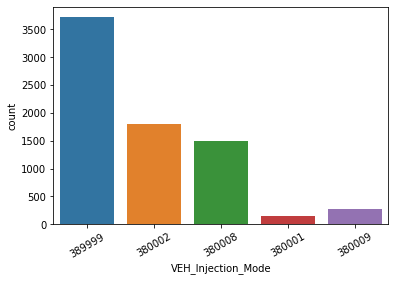

In [47]:
sn.countplot(data = dataset_mod, x = 'VEH_Injection_Mode')
plt.xticks(rotation=30)
plt.show()

In [48]:
dataset_mod['VEH_Injection_Mode'] = dataset_mod['VEH_Injection_Mode'].fillna((dataset_mod['VEH_Injection_Mode'].mode()[0]))

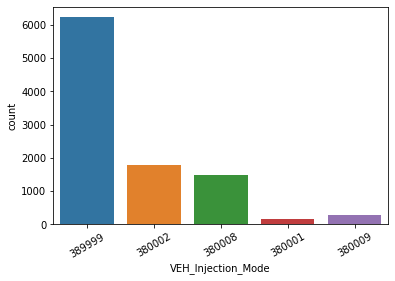

In [49]:
sn.countplot(data = dataset_mod, x = 'VEH_Injection_Mode')
plt.xticks(rotation=30)
plt.show()

In [50]:
dataset_mod.isnull().sum(axis=0)

Id                               0
Response_Market_Index            0
PROD_Formula                     0
PER_sex                          0
PER_Sex_Second_Driver            0
VEH_Actual_Value                 0
CLA_HISTORY                      0
CLA_HISTORY_1Y                   0
CLA_HISTORY_3Y                   0
CLA_BM_TPL_DECLARED              0
BEH_Mileage                      0
PER_KIDS_ON_BOARD_ID             0
VEH_Number_of_doors              0
VEH_Top_Speed                    0
BEH_Number_Year_Insured          0
VEH_TransmissionId               0
PER_Age_Main_Driver              0
PER_License_Age_Main_Driver      0
PER_License_Age_Second_Driver    0
PER_Matrimonial_Status           0
VEH_Age                          0
VEH_Injection_Mode               0
VEH_fuel_type                    0
VEH_Drive_type                   0
VEH_Body                         0
VEH_Segment                      0
PER_Parking_Type                 0
CLA_BM                           0
VEH_engine_HP       



## 6. Modeling and evaluation 

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

In [52]:
X = dataset_mod[[col for col in list(dataset_mod.columns) if col != 'Response_Market_Index']]
y = dataset_mod.Response_Market_Index

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
reg = RandomForestRegressor(n_estimators=100)
reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

In [54]:
mean_absolute_error(y_test, y_pred)

40.65482859060402

In [55]:
mean_absolute_error(y_train, y_train_pred)

15.584362217747739

In [56]:
median_absolute_error(y_test, y_pred)

16.519100000000094

In [57]:
median_absolute_error(y_train, y_train_pred)

6.4302000000000135

In [58]:
r2_score(y_train, y_train_pred)


0.9860926503906591

In [59]:
r2_score(y_test, y_pred)

0.9059876440023386

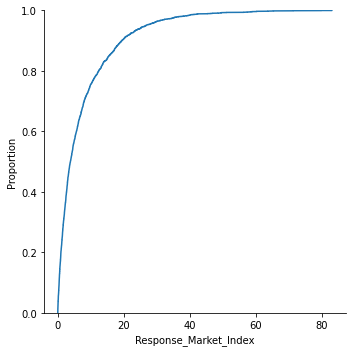

In [60]:
mape = np.abs((y_test - y_pred) / y_test) * 100
sn.displot(mape, kind="ecdf")

In [61]:
dataset_y_pred = pd.DataFrame(data=y_pred, columns=['y_pred'])
dataset_y_test = pd.DataFrame(data=list(y_test), columns=['y_test'])
dataset_mape = pd.DataFrame(data=list(mape), columns=['mape'])
dataset_error = pd.concat([dataset_y_pred, dataset_y_test, dataset_mape], axis=1)
dataset_error.head(10)

,y_pred,y_test,mape
0,413.3642,408.20,1.265115
1,319.9496,309.00,3.543560
2,843.1516,896.00,5.898259
3,304.1858,299.00,1.734381
4,365.4302,370.70,1.421581
5,367.8177,362.96,1.338357
6,630.9695,579.00,8.975734
7,591.0975,576.17,2.590815
8,489.1963,506.43,3.402978
9,373.6443,349.00,7.061404


In [62]:
dataset_error.describe()

,y_pred,y_test,mape
count,2980.000000,2980.000000,2980.000000
mean,488.873274,491.376178,7.527664
std,239.736945,264.797322,9.713930
min,225.061000,162.000000,0.000000
25%,353.041800,339.500000,1.341837
50%,407.902600,408.350000,3.824805
75%,524.072725,527.512500,9.809928
max,1840.450500,2201.680000,83.106862


In average, the mean absolute percentage error is `7.52%` which means that the prediction is very accurate. However, the model works better for the train data : the mean absolute error is equal to `40.65` for the test set, and it is equal to `15.58` for the train test.

This may indicate bad overfitting, but not necessarily. We want to try to improve the model anyway, and see if we can get the performances to be as close as possible. We will try to optimise the hyper-parameters of the model used.



# 7. Dealing with overfitting

In [63]:
from sklearn.model_selection import GridSearchCV
rdfr = RandomForestRegressor(random_state=1, n_estimators=100)

parameters = {'max_features':list(range(18,33)),'max_depth':list(range(5,15))}
clf = GridSearchCV(estimator=rdfr,param_grid=parameters,scoring='neg_mean_absolute_error')
clf.fit(X_train,y_train)



GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [64]:
clf.best_params_

{'max_depth': 14, 'max_features': 26}

In [80]:
reg = RandomForestRegressor(random_state=1, n_estimators=100, max_depth=14, max_features=26)
reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

In [81]:
mean_absolute_error(y_train, y_train_pred)

29.683629482997997

In [82]:
mean_absolute_error(y_test, y_pred)

50.79633532547614

In [83]:
median_absolute_error(y_train, y_train_pred)

20.96135726223264

In [84]:
median_absolute_error(y_test, y_pred)

30.58277597828763

In [85]:
r2_score(y_train, y_train_pred)

0.9749659807897079

In [86]:
r2_score(y_test,y_pred)

0.892672267585553

The difference in performance between the train set and the test set are a little smaller, which is better. We could also try using `GradientBoostingRegressor` but for now the results with Random Forest are satisfactoy.


**For further analysis, and better, more accurate prediction, it can be interesting to analyse the outliers in more detail. It can also be interesting to broaden the range of the parameters in the `GridSearch`. Or to add a validation set, in order to choose the best model.**

# 8. Interpretability

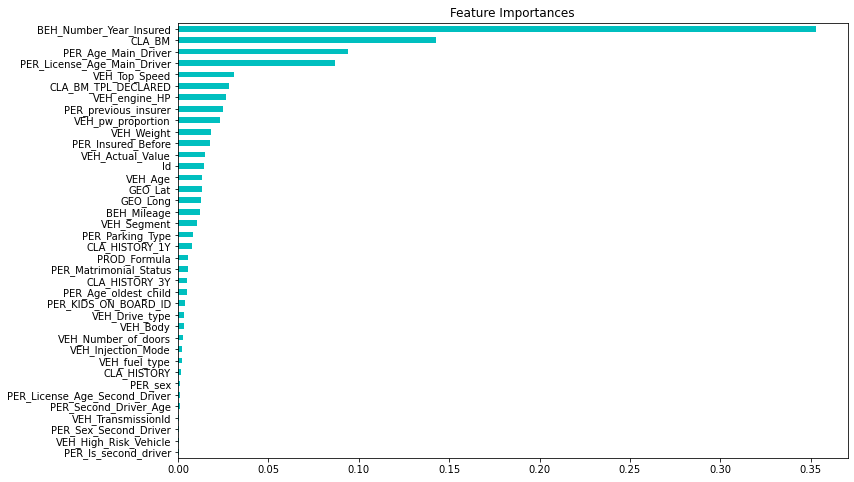

In [87]:
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
feat_importances.nsmallest(40).plot(kind='barh',color='c')

In [88]:
!pip install shap
import shap
shap.initjs()

In [74]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

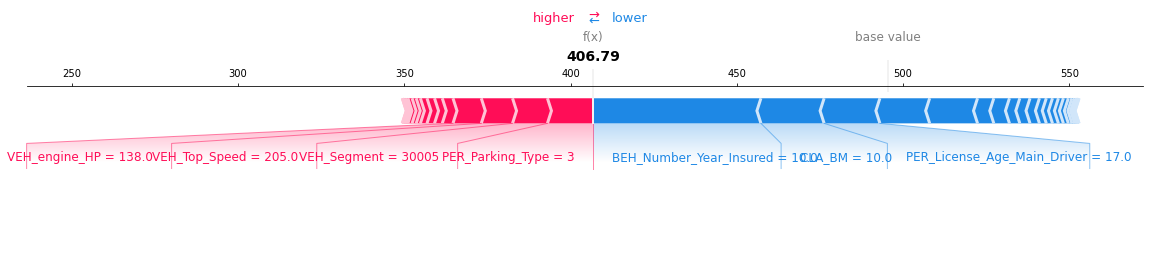

In [89]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)

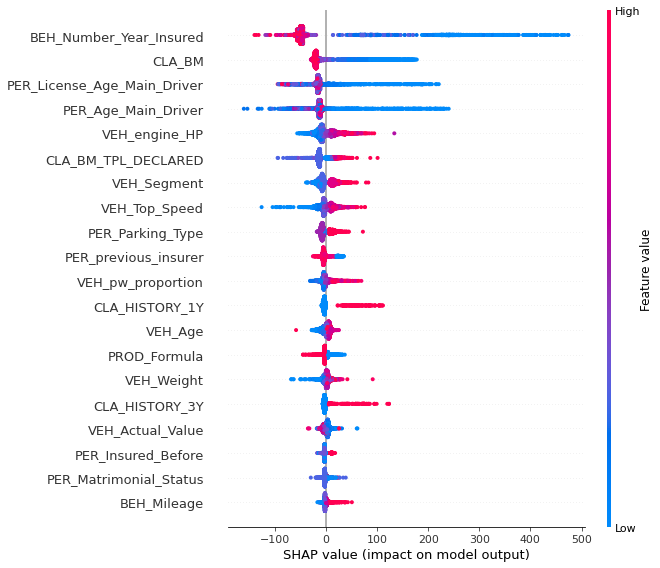

In [90]:
shap.summary_plot(shap_values, X_test)

As seen in the first plot of feature importances, the four most important features are `BEH_Number_Year_Insured`, `CLA_BM`, `PER_License_Age_Main_Drive` and `PER_Age_Main_Driver`. For example, for the first prediction (`406.79`), we can see that `BEH_Number_Year_Insured`, with a value equal to 10 and therefore greater than the average 6.58, pushes the prediction to the left (negatively). However `VEH_Top_Speed`, with a value equal to 205 which is greater than the average 188, pushes the prediction to the right (positively).

In [91]:
X_test.mean()

Id                                        inf
PROD_Formula                     6.305369e-01
PER_sex                                   inf
PER_Sex_Second_Driver                     inf
VEH_Actual_Value                 2.078748e+04
CLA_HISTORY                      1.519128e+00
CLA_HISTORY_1Y                   1.120470e+00
CLA_HISTORY_3Y                   1.338255e+00
CLA_BM_TPL_DECLARED              1.667114e+00
BEH_Mileage                      1.333456e+01
PER_KIDS_ON_BOARD_ID                      inf
VEH_Number_of_doors              4.574161e+00
VEH_Top_Speed                    1.884346e+02
BEH_Number_Year_Insured          6.583893e+00
VEH_TransmissionId                        inf
PER_Age_Main_Driver              3.835671e+01
PER_License_Age_Main_Driver      1.701544e+01
PER_License_Age_Second_Driver    8.385906e-01
PER_Matrimonial_Status                    inf
VEH_Age                          8.842617e+00
VEH_Injection_Mode                        inf
VEH_fuel_type                     

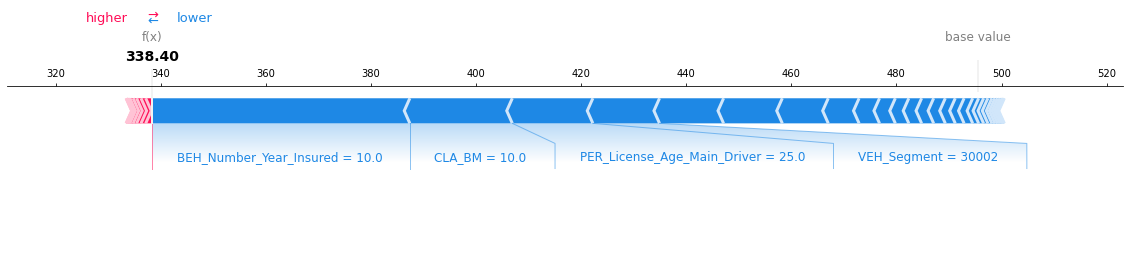

In [92]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:],matplotlib=True)

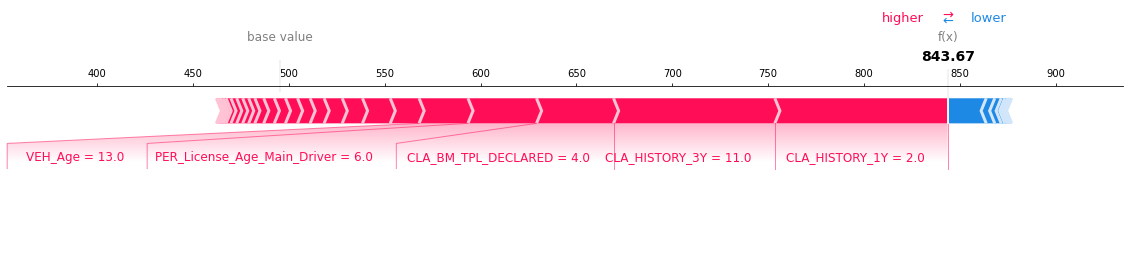

In [93]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:],matplotlib=True)